In [12]:
import numpy as np
import pathpy as pp

def generate_bipartite_block_probs(dict_p_stud_to_task):
    n_groups_from_dict_values = set(len(v) for v in dict_p_stud_to_task.values())
    assert len(n_groups_from_dict_values)==1, "Input dict_p_stud_to_task implies varying number of groups"
    n_groups= list(n_groups_from_dict_values)[0]
    assert n_groups==len(dict_p_stud_to_task), "not enough keys"

    bip_block_probs = np.zeros((2*n_groups, 2*n_groups))
    # Fill in the probabilities within and between groups
    # Only filling probs of students to interact with tasks. 
    # Since the interactions are symmetric, the information on tasks interacting with studetns is redundant and can be obtained by summing with the transpose (see below )
    #
    # even indexes for students
    for row in range(0,2*n_groups,2):
        # odd indexes are for tasks
        for col in range(1,2*n_groups,2):
            stud_ix = row//2
            task_ix = int(col/2)
            bip_block_probs[row,col] = dict_p_stud_to_task[stud_ix][task_ix]
    return bip_block_probs + bip_block_probs.T



def sample_dcsbm(num_nodes, B, expected_degrees):
    """
    Samples a network from a degree-corrected stochastic block model
    """
    # assert False, "check that num blcks an block matrix agree"
    assert B.shape[0] == B.shape[1], "B should be square"
    num_blocks = B.shape[0]
    m = np.random.choice(num_blocks, size=num_nodes)

    # generate edges
    edge_list = []
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            p_edge = B[m[i], m[j]]*expected_degrees[i]*expected_degrees[j]/(sum(expected_degrees))
            p_edge = min(p_edge, 1)
            assert p_edge <= 1, f"Edge probability larger than 1: {p_edge}"
            if np.random.rand() < p_edge:
                edge_list.append((i, j))

    # Create a graph and add nodes
    # network = pp.Network()
    # for u,v in edge_list:
    #     network.add_edge(u,v)
    
    # return network
    return edge_list, m

# num_nodes = 500
# # dictionary with stud index-topic as key, and list of probabiliy of interacting with task of other index-topics
# dict_p_stud_to_task = {}
# dict_p_stud_to_task[0] = [1,0,0]#,.00005]
# dict_p_stud_to_task[1] = [0,1,0]#,.001]
# dict_p_stud_to_task[2] = [0,0,1]
# bip_block_probs = generate_bipartite_block_probs(dict_p_stud_to_task)
# # print(bip_block_probs)


# theta = np.random.randint(1,num_nodes//3,num_nodes) #np.random.uniform(low=1, high=1, size=num_nodes)  # Random 
# # theta = [int(np.random.exponential(20)) for _ in range(num_nodes)]# np.random.randint(1,100,num_nodes) #np.random.uniform(low=1, high=1, size=num_nodes)  # Random 
# edges,labels = sample_dcsbm(num_nodes, bip_block_probs, theta)

In [13]:
# from collections import Counter
# Counter(labels)

In [14]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from manage_experiments import *

from utils import generate_multidimensional_data_object_synthetic_geometric

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import json

In [15]:
# student_indices = [j for i,j in zip(labels, range(len(labels))) if i%2==0]
# student_reindexed = {j:i for i,j in enumerate(student_indices)}
# task_indices = [j for i,j in zip(labels, range(len(labels))) if i%2==1]
# task_reindexed = {j:i for i,j in enumerate(task_indices)}
# n_students = len(student_indices)
# n_tasks = len(task_indices)

# edge_reordered_reindexed = []
# for edge in edges:
#     if edge[0] in student_indices:
#         e = (student_reindexed[edge[0]], task_reindexed[edge[1]])
#     else:
#         e = (student_reindexed[edge[1]], task_reindexed[edge[0]])
#     edge_reordered_reindexed.append(e)

# # mapping groups to new indexing and node type separation
# student_groups = np.zeros(n_students,dtype=int)
# tasks_groups = np.zeros(n_tasks, dtype=int)

# for old_ix, new_ix in student_reindexed.items():
#     student_groups[new_ix] = labels[old_ix]

# for old_ix, new_ix in task_reindexed.items():
#     tasks_groups[new_ix] = labels[old_ix]

# # Maiking students interact with tasks according to generated topology
# p_pass_in = .9
# p_pass_out = .1
# y = []
# for s_ix, t_ix in edge_reordered_reindexed:
#     if student_groups[s_ix] == tasks_groups[t_ix]:
#         p = p_pass_in
#     else:
#         p = p_pass_out
#     y.append(np.random.binomial(1,p))
    

In [16]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def logarithm_base(x, base):
    return np.log(x)/np.log(base)

In [17]:
import torch_geometric.transforms as T

def create_data_object_SBM(edges, labels, bip_block_p_pass_probs, theta, base, degree_p_pass_correction=True):

    student_indices = [j for i,j in zip(labels, range(len(labels))) if i%2==0]
    student_reindexed = {j:i for i,j in enumerate(student_indices)}
    task_indices = [j for i,j in zip(labels, range(len(labels))) if i%2==1]
    task_reindexed = {j:i for i,j in enumerate(task_indices)}
    n_students = len(student_indices)
    n_tasks = len(task_indices)

    edge_reordered_reindexed = []
    for edge in edges:
        if edge[0] in student_indices:
            e = (student_reindexed[edge[0]], task_reindexed[edge[1]])
        else:
            e = (student_reindexed[edge[1]], task_reindexed[edge[0]])
        edge_reordered_reindexed.append(e)

    # mapping groups to new indexing and node type separation
    student_groups = np.zeros(n_students,dtype=int)
    tasks_groups = np.zeros(n_tasks, dtype=int)

    for old_ix, new_ix in student_reindexed.items():
        student_groups[new_ix] = labels[old_ix]

    for old_ix, new_ix in task_reindexed.items():
        tasks_groups[new_ix] = labels[old_ix]


    # Maiking students interact with tasks according to generated topology
    # p_pass_in = .9
    # p_pass_out = .1
    y = []
    theta_m = max(theta)
    # tau = .0
    # eta = .99
    # s = - np.log((1 + eta) / eta) / theta_m
    # print(s)
    for s_ix, t_ix in edge_reordered_reindexed:
        # if student_groups[s_ix] == tasks_groups[t_ix]:
        #     p = p_pass_in
        # else:
        #     p = p_pass_out
        p_pass = bip_block_p_pass_probs[student_groups[s_ix], tasks_groups[t_ix]]
        if degree_p_pass_correction:
            correction = logarithm_base(theta[s_ix], base)/logarithm_base(theta_m, base)#tau + (1 - tau)*sigmoid(s * theta[s_ix])
            p_pass = p_pass * correction
        y.append(np.random.binomial(1, p_pass))
    

    data  = HeteroData()

    # Save node indices
    data['student'].node_id = torch.arange(n_students)
    data['item'].node_id = torch.arange(n_tasks)


    # Add the node features
    data['student'].x= torch.eye(n_students)
    data['item'].x = torch.eye(n_tasks)

    # Add the edge indices
    data['student', 'responds', 'item'].edge_index = torch.from_numpy(np.array(edge_reordered_reindexed).T).to(torch.long)

    #add the edge attrs
    data['student', 'responds', 'item'].edge_attr = torch.tensor([1]*len(y)).to(torch.float).reshape(-1,1)

    # Add the edge label
    data['student', 'responds', 'item'].y = torch.from_numpy(np.array(y)).to(torch.long)

    # We use T.ToUndirected() to add the reverse edges from subject to students 
    # in order to let GNN pass messages in both ways
    data = T.ToUndirected()(data)
    del data['item', 'rev_responds', 'student'].edge_attr  # Remove 'reverse' label.
    del data['item', 'rev_responds', 'student'].y  # Remove 'reverse' label.
    return data


def generate_data_object_SBM(num_nodes, bip_block_probs, theta, bip_block_p_pass_probs, base, degree_p_pass_correction=False):
    edges, labels = sample_dcsbm(num_nodes, bip_block_probs, theta) #generate_observations_tree_of_topics(n, n_students, n_tasks, tree_depth,branching_factor,p_ER,skill_mismatch_penalty)
    data = create_data_object_SBM(edges, labels, bip_block_p_pass_probs, theta, base, degree_p_pass_correction)
    # print("network density",data.num_edges/(2*n_students*n_tasks))
    return data


# data_object = generate_data_object_SBM(num_nodes, bip_block_probs, theta)
# data_object

In [18]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def line_plot_with_std(list_scores, parameters, fname):

    # Convert the list of lists to a Pandas DataFrame
    df = pd.DataFrame(list_scores)

    # Calculate the mean and standard deviation of each row
    mean = df.mean(axis=1)
    std = df.std(axis=1)

    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Plot the mean line
    ax.plot(mean, color='blue', label='Mean')

    # Plot the shaded region around the mean line
    ax.fill_between(df.index, mean-std, mean+std, color='lightblue', alpha=0.5, label='Standard deviation')

    # Add some labels and a legend
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    # ax.legend()

    # change x-ticks to start from 
    n_tasks_per_student_list = list(range(
        parameters['min_n_tasks_per_student'],
        parameters['max_n_tasks_per_student'],
        parameters['step_n_tasks_per_student']))
    ax.set_xticks(range(len(n_tasks_per_student_list)), n_tasks_per_student_list, rotation=45)

    # Show and save the plot
    plt.grid()
    plt.xlabel('Number of tasks per student')
    plt.ylabel('Balanced Accuracy')
    fnameplot = fname.replace('results', 'pdf')
    plt.savefig(fnameplot)
    # plt.show()


In [19]:
def visualise_confusion_matrix(json_content, fname):
    fig, ax = plt.subplots(ncols = 1, figsize=(8,6))
    
    plt.imshow(json_content["Confusion_2_test"], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = [0, 1]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    part1, part2 = fname.split('.')
    part1 = part1 + '_consfusion_matrix'
    fname = '.'.join([part1, part2])
    fnameplot = fname.replace('results', 'pdf')
    plt.savefig(fnameplot)

In [20]:
from IPython.utils import io
import matplotlib.pyplot as plt

import string
def create_filename_results(parameters,fold):
    file_name = ' '.join([f"{str(key)}-{str(value)}" for key, value in parameters.items() if key not in ['bip_block_probs','theta','bip_block_p_pass_probs']])
    file_name += ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(4))
    file_name.replace(".","")
    file_name+=".results"
    return os.path.join(fold, file_name)


#n_students_per_task_list = [2**i for i in n_students_per_task_list]

import json
def synthetic_density_effect_runs(data, parameters,parameters_density, folder = 'p_pass_degree_correction_true'):
    parameters = {**parameters, **parameters_density}
    scores = []
    list_scores = []
    for _ in range(parameters["n_runs"]):
        with io.capture_output() as captured:
            
            cv_out = perform_cross_validation(data, parameters, save_embeddings=True)

            score = 0
            inner_list_scores = []
            for fold_n in range(parameters["n_splits"]):
                score += cv_out[f"Balanced Accuracy_{fold_n}_test"]
                inner_list_scores.extend([cv_out[f"Balanced Accuracy_{fold_n}_test"]])
            score = score / parameters["n_splits"]
            scores.append(score)
            list_scores.append(inner_list_scores)

    # density = data.num_edges/(2*parameters["n_students"]*parameters["n_tasks"]) 
    res_dict = dict(zip(list(range(parameters["n_runs"])),scores))
    output_dict = {
        **parameters,
        # "density":density,
        "res_dict":res_dict,
        "list_scores":dict(zip(list(range(parameters["n_runs"])),list_scores))
    }
    output_dict['bip_block_probs'] = output_dict['bip_block_probs'].tolist()
    output_dict['theta'] = output_dict['theta'].tolist()
    output_dict['bip_block_p_pass_probs'] = output_dict['bip_block_p_pass_probs'].tolist()
    fname = create_filename_results(parameters_density, folder)
    # print the types of items
    # print({i: type(output_dict[i]) for i,j in output_dict.items()})
    with open(fname,'w') as f:
        json.dump(output_dict, f, skipkeys=True)
    
    # save results
    # print(density)
    print([np.mean(s) for s in list_scores])
    # line_plot_with_std(list_scores=list_scores, parameters= parameters, fname=fname)

    # # save embeddings
    # visualise_embeddings(output_dict, fname=fname)

    # visualise_embeddings_concatenated(output_dict, data['student', 'responds', 'item'].edge_index, data['student', 'item'].y, fname = fname) # plot with indices of train-test split
    
    # # plot with indices of train-test split
    


    # visualise_confusion_matrix(cv_out, fname=fname)

In [21]:
parameters = {
    "hidden_dims": None,
    'model_type': None,
    "df_name": "synthetic.salamoia",
    "method": "EdgeClassifier",
    "epochs": 2000,
    "learning_rate": 0.05,
    "weight_decay": 0,
    "dropout": 0.0,
    "early_stopping": 250,
    "n_splits": 15,
    "device": "cuda",
    "done": False,
    "batch_size":64*4096,
    #
    }

# n_groups = 3
# # probability of connections between students and tasks
# dict_p_stud_to_task = {}
# dict_p_stud_to_task[0] = [1,1/(n_groups - 1),1/(n_groups - 1)]
# dict_p_stud_to_task[1] = [1/(n_groups - 1),1,1/(n_groups - 1)]
# dict_p_stud_to_task[2] = [1/(n_groups - 1),1/(n_groups - 1),1]
# bip_block_probs = generate_bipartite_block_probs(dict_p_stud_to_task)
# # probability of passing a task given the student and the task
# dict_p_pass_stud_to_task = {}
# dict_p_pass_stud_to_task[0] = [.8,.1,.05]
# dict_p_pass_stud_to_task[1] = [.2,.7,.1]
# dict_p_pass_stud_to_task[2] = [.1,.3,.6]
# bip_block_p_pass_probs = generate_bipartite_block_probs(dict_p_stud_to_task)

# theta = np.random.randint(1,num_nodes//3,num_nodes)

parameters_density = {
    'n_runs': 1,
    'num_nodes':500,
    'bip_block_probs':None,
    'bip_block_p_pass_probs':None,
    'theta':None,
    'n_groups':None,
    'theta_type':None,
    'p_pass_out': None,
    'p_pass_in': None,	
    'degree_p_pass_correction': False,
}


In [22]:
# NB: having only the leaves might make it easier for IRT since it just creates separated bins (i.e., the leaves) and easy tasks (the ones sampled close to the root node)
#  Instead, with a GNN we want to leverage the ...ability to encode the underlying tree structure (HOW might the GNN do it, specifically?)
std = parameters_density["num_nodes"]/100
for n_groups in [3,4,5]:
    parameters_density['n_groups'] = n_groups
    for theta in [(np.random.lognormal(mean=np.log(20),sigma=np.log(2),size=parameters_density["num_nodes"]), 'lognormal'), (np.random.normal(parameters_density["num_nodes"]/n_groups, std, parameters_density["num_nodes"]), "gaussian"), (np.random.randint(1,parameters_density["num_nodes"]//n_groups,parameters_density["num_nodes"]), "uniform")]:#, (np.random.exponential(100,parameters_density["num_nodes"]), "exponential")]:
        parameters_density['theta'] = theta[0]
        parameters_density['theta_type'] = theta[1]
        for mul_p_connection in [1, 1/2, 1/3, 2/3]:
            parameters_density['mul_p_connection'] = mul_p_connection
            dict_p_stud_to_task = {}
            for i in range(n_groups):
                dict_p_stud_to_task[i] = [0.5]*n_groups#[mul_p_connection/(n_groups-1)]*n_groups
                dict_p_stud_to_task[i][i] = 0.5#1
            bip_block_probs = generate_bipartite_block_probs(dict_p_stud_to_task)
            parameters_density['bip_block_probs'] = bip_block_probs
            parameters_density['p_pass_in'] = 1
            for p_pass_out in [.1, .3, .5, .7]:
                dict_p_pass_stud_to_task = {}
                for i in range(n_groups):
                    dict_p_pass_stud_to_task[i] = [p_pass_out]*n_groups
                    dict_p_pass_stud_to_task[i][i] = 1
                parameters_density['p_pass_out'] = p_pass_out
                bip_block_p_pass_probs = generate_bipartite_block_probs(dict_p_pass_stud_to_task)
                parameters_density['bip_block_p_pass_probs'] = bip_block_p_pass_probs

                for base in [5,10]:
                    parameters_density['base'] = base

                    parameters = {**parameters, **parameters_density}
                    data = generate_data_object_SBM(
                    num_nodes= parameters["num_nodes"],
                    bip_block_probs = parameters["bip_block_probs"],
                    theta = parameters["theta"],
                    bip_block_p_pass_probs = parameters["bip_block_p_pass_probs"],
                    base = parameters["base"],
                    degree_p_pass_correction=parameters["degree_p_pass_correction"]
                    )
                    
                    for model_type,hidden_dims in [
                        ("IRT",3),
                        ("GNN", [
                            16,
                            16,
                            8])]:
                        parameters["model_type"] = model_type
                        parameters["hidden_dims"] = hidden_dims
                        print('Model type:', model_type, 'hidden_dims:', hidden_dims, 'n_groups:', n_groups, 'theta:', theta[1], 'mul_p_connection:', mul_p_connection, 'p_pass_out:', p_pass_out, 'base:', base)
                        print('y counts', torch.bincount(data['student', 'responds', 'item'].y))
                        synthetic_density_effect_runs(data, parameters=parameters,
                                                    parameters_density=parameters_density,
                                                    )

Model type: IRT hidden_dims: 3 n_groups: 3 theta: lognormal mul_p_connection: 1 p_pass_out: 0.1 base: 5
y counts tensor([961, 676])
[0.5119206066185702]
Model type: GNN hidden_dims: [16, 16, 8] n_groups: 3 theta: lognormal mul_p_connection: 1 p_pass_out: 0.1 base: 5
y counts tensor([961, 676])
[0.5096313827072172]
Model type: IRT hidden_dims: 3 n_groups: 3 theta: lognormal mul_p_connection: 1 p_pass_out: 0.1 base: 10
y counts tensor([974, 644])
[0.5061021733860847]
Model type: GNN hidden_dims: [16, 16, 8] n_groups: 3 theta: lognormal mul_p_connection: 1 p_pass_out: 0.1 base: 10
y counts tensor([974, 644])
[0.5231291232838474]
Model type: IRT hidden_dims: 3 n_groups: 3 theta: lognormal mul_p_connection: 1 p_pass_out: 0.3 base: 5
y counts tensor([755, 875])
[0.48428457731130287]
Model type: GNN hidden_dims: [16, 16, 8] n_groups: 3 theta: lognormal mul_p_connection: 1 p_pass_out: 0.3 base: 5
y counts tensor([755, 875])
[0.5151420736324136]
Model type: IRT hidden_dims: 3 n_groups: 3 theta:

FileNotFoundError: [Errno 2] No such file or directory: 'p_pass_degree_correction_true\\n_runs-1 num_nodes-500 n_groups-3 theta_type-lognormal p_pass_out-0.1 p_pass_in-1 degree_p_pass_correction-False mul_p_connection-0.3333333333333333 base-10mqw5.results'

In [23]:
import os
import pandas as pd
import json
import numpy as np

def read_json_files(directory):
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".results"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                json_data = json.load(file)
                data.append(json_data)
    df = pd.DataFrame(data)
    return df

In [24]:
df = read_json_files('p_pass_degree_correction_true')

In [25]:
# df['list_scores_latex'] = df['list_scores'].apply(lambda x: f"{np.mean([np.mean(v)*100 for v in x.values()]):.2f} ± {np.std([np.mean(v)*100 for v in x.values()]):.2f}")
df['list_scores_latex'] = df['list_scores'].apply(lambda x: f"{np.mean([v for v in x.values()])*100:.2f} ± {np.std([v for v in x.values()])*100:.2f}")

In [26]:
group_cols = [
    'p_pass_out', 
    # 'bip_block_p_pass_probs', 
    'theta_type', 
    'n_groups', 
    'mul_p_connection',
    'model_type'
    ]

In [27]:
grouped = df.groupby(group_cols).agg({
    'list_scores': lambda x: x.apply(lambda y: np.mean([v for v in y.values()])),
    }).reset_index()

In [28]:
std_list = []
mean_list = []
for dict_values in df.list_scores.values:
    std_list.append(np.std(dict_values['0']))
    mean_list.append(np.mean(dict_values['0']))

df['std'] = std_list
df['mean'] = mean_list

In [29]:
def col_selector(df, cols, values):
    mask = np.full(len(df), True)
    for col, value in zip(cols, values):
        mask = mask & (df[col] == value)
    return mask

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_line_graph(df, xaxis_col, list_scores_col, label=""):
    # Set the style of the plot
    sns.set_style("darkgrid")
    # Set color palette
    sns.set_palette("colorblind")

    # Create the plot
    x_values = df[xaxis_col]
    y_mean = df[list_scores_col].apply(lambda x: np.mean(x))
    y_std = df[list_scores_col].apply(lambda x: np.std(x))

    # Create an error bar plot with a line marker style
    plt.errorbar(x_values, y_mean, yerr=y_std, fmt='-o', label=label, capsize=5)

    # Set the labels and title
    plt.xlabel(xaxis_col, fontsize=16)
    plt.ylabel('Mean Scores', fontsize=16)
    plt.title('Line Graph', fontsize=20)
    plt.ylim(20, 100)

    # Add a legend
    plt.legend(fontsize=14)

    # Show the plot
    # plt.show()

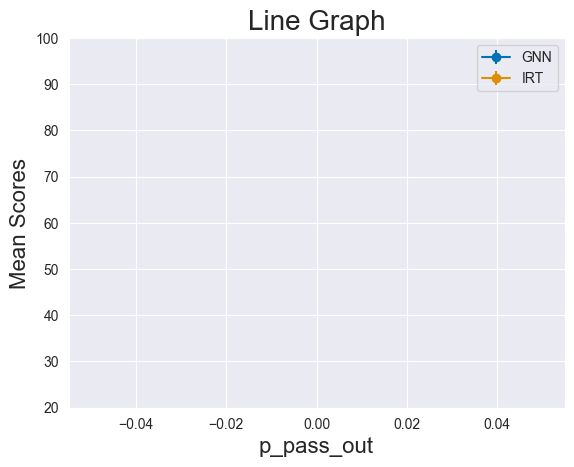

In [31]:
df_select_GNN = df[col_selector(df, ['theta_type', 'n_groups', 'mul_p_connection', 'model_type'], ['uniform', 3, 1/2, 'GNN'])]
df_select_IRT = df[col_selector(df, ['theta_type', 'n_groups', 'mul_p_connection', 'model_type'], ['uniform', 3, 1/2, 'IRT'])]

plot_line_graph(df_select_GNN, 'p_pass_out', 'mean', label='GNN')
plot_line_graph(df_select_IRT, 'p_pass_out', 'mean', label='IRT')
plt.legend()

In [32]:
# df_select_GNN = grouped[col_selector(grouped, ['theta_type', 'n_groups', 'mul_p_connection', 'model_type'], ['lognormal', 3, 1/2, 'GNN'])]
# df_select_IRT = grouped[col_selector(grouped, ['theta_type', 'n_groups', 'mul_p_connection', 'model_type'], ['lognormal', 3, 1/2, 'IRT'])]

# plot_line_graph(df_select_GNN, 'p_pass_out', 'list_scores', label='GNN')
# plot_line_graph(df_select_IRT, 'p_pass_out', 'list_scores', label='IRT')
# plt.legend()

In [33]:
grouped['Mean'] = grouped['list_scores'].apply(lambda x: round(np.mean(x),2))
grouped['Std'] = grouped['list_scores'].apply(lambda x: round(np.std(x),2))

In [34]:
# df_list = []
# for group, df_group in grouped.groupby(['n_groups', 'theta_type', 'mul_p_connection', 'p_pass_out']):
#     try:
#         gain = (df_group[df_group['model_type'] == 'GNN']['Mean'].values[0] - df_group[df_group['model_type'] == 'IRT']['Mean'].values[0]) / df_group[df_group['model_type'] == 'IRT']['Mean'].values[0]*100
#         std = np.sqrt((df_group[df_group['model_type'] == 'GNN']['Std'].values[0])**2 + (df_group[df_group['model_type'] == 'IRT']['Std'].values[0])**2)
#         df_list.append(pd.DataFrame({
#             'n_groups': [group[0]],
#             'theta_type': [group[1]],
#             'mul_p_connection': [group[2]],
#             'p_pass_out': [group[3]],
#             'gain': [gain],
#             'std': [std]	
#         }))
#     except:
#         continue

df_list = []
for group, df_group in df.groupby(['n_groups', 'theta_type', 'mul_p_connection', 'p_pass_out']):
    try:
        gain = (df_group[df_group['model_type'] == 'GNN']['mean'].values[0] - df_group[df_group['model_type'] == 'IRT']['mean'].values[0]) / df_group[df_group['model_type'] == 'IRT']['mean'].values[0]*100
        std = np.sqrt((df_group[df_group['model_type'] == 'GNN']['std'].values[0])**2 + (df_group[df_group['model_type'] == 'IRT']['std'].values[0])**2)
        df_list.append(pd.DataFrame({
            'n_groups': [group[0]],
            'theta_type': [group[1]],
            'mul_p_connection': [group[2]],
            'p_pass_out': [group[3]],
            'gain': [gain],
            'std': [std],
            'bottom': df_group[df_group['model_type'] == 'IRT']['mean'].values[0]*100	
        }))
    except:
        continue

In [35]:
new_df = pd.concat(df_list)

In [36]:
new_df.columns

Index(['n_groups', 'theta_type', 'mul_p_connection', 'p_pass_out', 'gain',
       'std', 'bottom'],
      dtype='object')

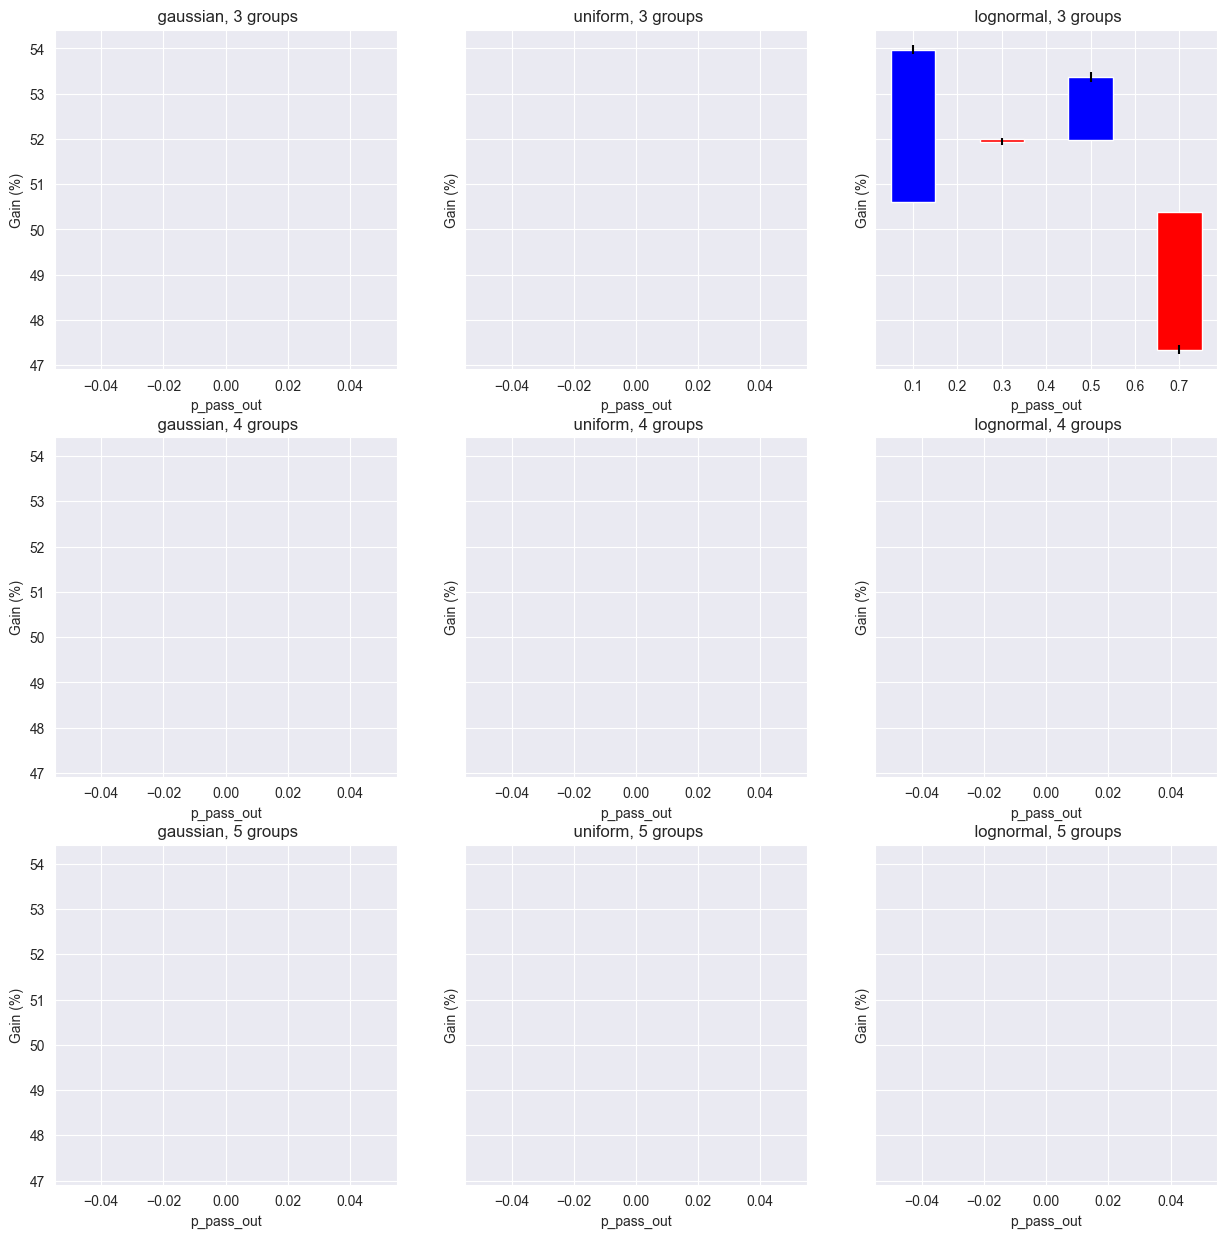

In [39]:

mul_p_connection = 1


theta_types = ['gaussian', 'uniform', 'lognormal']
n_groups = [3, 4, 5]

fig, axes = plt.subplots(
    len(n_groups),
    len(theta_types),
    figsize=(15, 15),
    sharey=True
    )
for theta_type in theta_types: 
    for ng in n_groups:
        col = theta_types.index(theta_type)
        row = n_groups.index(ng)
        sub_new_df = new_df[
            (new_df['theta_type'] == theta_type) & 
            (new_df['n_groups'] == ng) & 
            (new_df['mul_p_connection'] == mul_p_connection)
            ]
        
        
        # sns.barplot(data=sub_new_df, x='p_pass_out', y='gain', ax = axes[row,col])
        # axes[row,col].set_title(f" {theta_type}, {ng} groups")
        # color the bars: redu if positive gain, blue if negative
        sub_new_df = sub_new_df.copy()
        sub_new_df['color'] = sub_new_df['gain'].apply(lambda x: 'blue' if x>0 else 'red')
        axes[row, col].bar(
            x=sub_new_df['p_pass_out'],
            height=sub_new_df['gain'],
            yerr=sub_new_df['std'],
            color=sub_new_df['color'].values.tolist(),
            width=0.1,
            align='center',
            bottom=sub_new_df['bottom']
            )
        axes[row,col].set_title(f" {theta_type}, {ng} groups")
        axes[row,col].set_xlabel('p_pass_out')
        axes[row,col].set_ylabel('Gain (%)')
        # axes[row,col].set_ylim(-20, 20)

# theta_type = 'uniform'
# n_groups = 3

# sub_new_df = new_df[(new_df['theta_type'] == theta_type) & (new_df['n_groups'] == n_groups) & (new_df['mul_p_connection'] == mul_p_connection)]


# fig, axes = plt.subplots(1, 1, figsize=(10, 15))


# sns.barplot(data=sub_new_df, x='p_pass_out', y='gain', ax = axes)
# axes.set_title("fucl")


In [ ]:
df[(df['model_type'] == 'GNN') & (df['mul_p_connection'] == 2/3) & (df['p_pass_out'] == 0.1) & (df['theta_type'] == 'lognormal') & (df['n_groups'] == 3)]

,hidden_dims,model_type,df_name,method,epochs,learning_rate,weight_decay,dropout,early_stopping,n_splits,...,theta_type,p_pass_out,p_pass_in,degree_p_pass_correction,mul_p_connection,res_dict,list_scores,list_scores_latex,std,mean
36,"[16, 16, 8]",GNN,synthetic.salamoia,EdgeClassifier,2000,0.05,0,0.0,250,15,...,lognormal,0.1,1,False,0.666667,{'0': 0.5003236585995388},"{'0': [0.47413793103448276, 0.5498533724340176...",50.03 ± 4.89,0.048859,0.500324


In [ ]:
df[(df['model_type'] == 'IRT') & (df['mul_p_connection'] == 2/3) & (df['p_pass_out'] == 0.1) & (df['theta_type'] == 'lognormal') & (df['n_groups'] == 3)]

,hidden_dims,model_type,df_name,method,epochs,learning_rate,weight_decay,dropout,early_stopping,n_splits,...,theta_type,p_pass_out,p_pass_in,degree_p_pass_correction,mul_p_connection,res_dict,list_scores,list_scores_latex,std,mean
37,3,IRT,synthetic.salamoia,EdgeClassifier,2000,0.05,0,0.0,250,15,...,lognormal,0.1,1,False,0.666667,{'0': 0.5007346422466465},"{'0': [0.5186781609195402, 0.595307917888563, ...",50.07 ± 7.39,0.073905,0.500735


In [ ]:
new_df_gaussian = new_df[new_df['theta_type'] == 'gaussian']
new_df_lognormal = new_df[new_df['theta_type'] == 'lognormal']
new_df_uniform = new_df[new_df['theta_type'] == 'uniform']

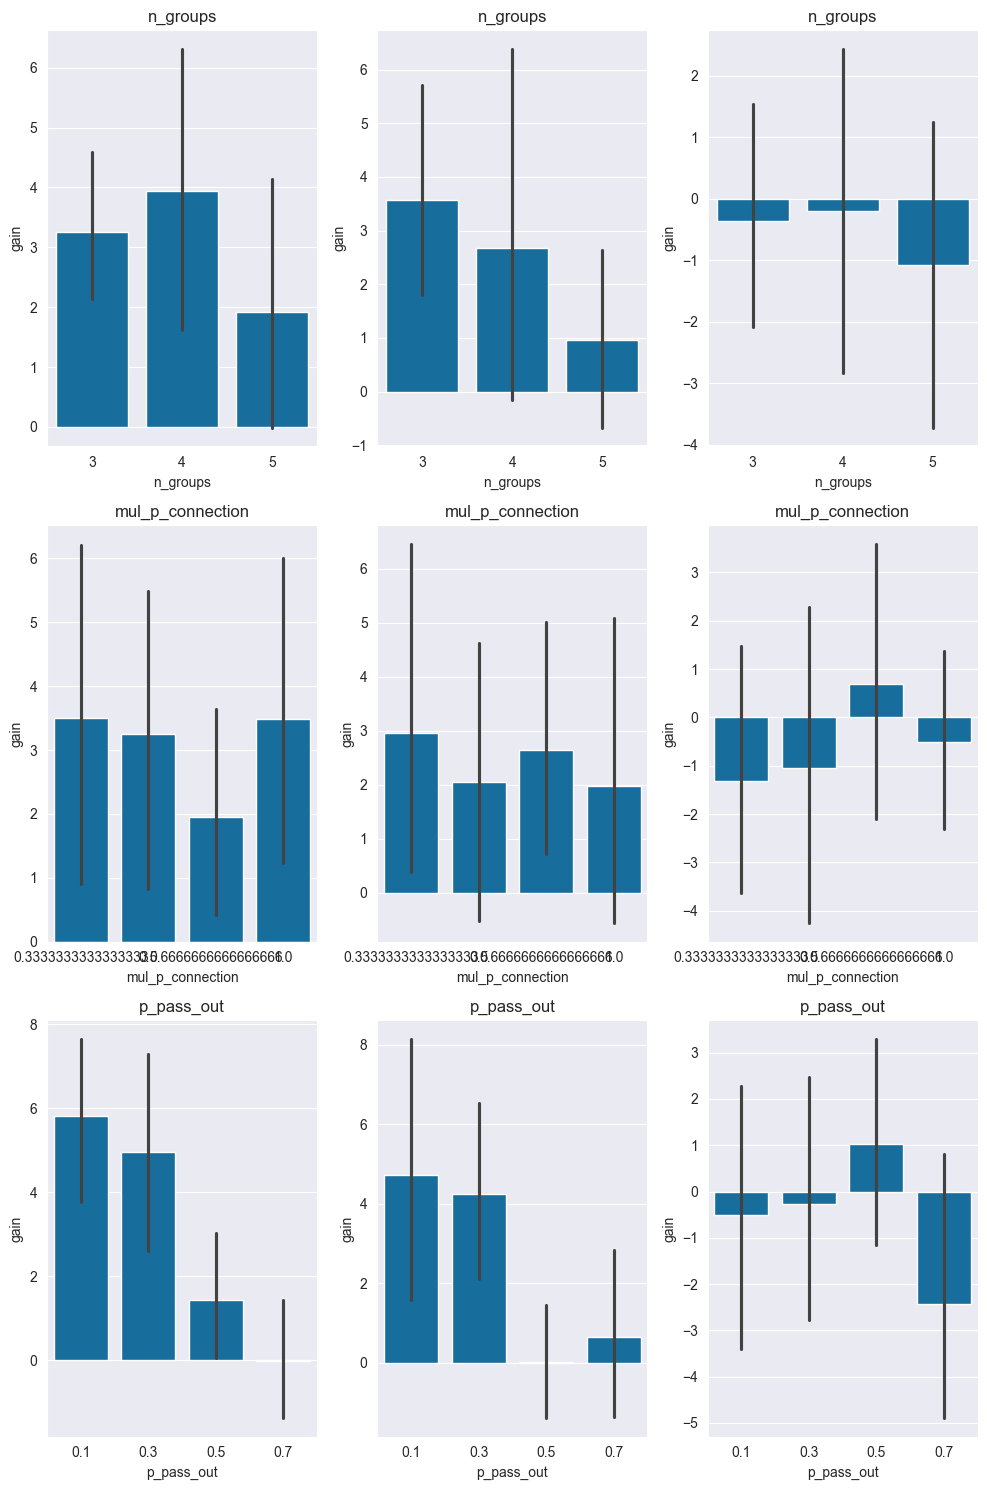

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(3, 3, figsize=(10, 15))

sns.barplot(x='n_groups', y='gain', data=new_df_gaussian, ax=axes[0,0])
axes[0,0].set_title('n_groups')

sns.barplot(x='mul_p_connection', y='gain', data=new_df_gaussian, ax=axes[1,0])
axes[1,0].set_title('mul_p_connection')

sns.barplot(x='p_pass_out', y='gain', data=new_df_gaussian, ax=axes[2,0])
axes[2,0].set_title('p_pass_out')


sns.barplot(x='n_groups', y='gain', data=new_df_uniform, ax=axes[0,1])
axes[0,1].set_title('n_groups')

sns.barplot(x='mul_p_connection', y='gain', data=new_df_uniform, ax=axes[1,1])
axes[1,1].set_title('mul_p_connection')

sns.barplot(x='p_pass_out', y='gain', data=new_df_uniform, ax=axes[2,1])
axes[2,1].set_title('p_pass_out')


sns.barplot(x='n_groups', y='gain', data=new_df_lognormal, ax=axes[0,2])
axes[0,2].set_title('n_groups')

sns.barplot(x='mul_p_connection', y='gain', data=new_df_lognormal, ax=axes[1,2])
axes[1,2].set_title('mul_p_connection')

sns.barplot(x='p_pass_out', y='gain', data=new_df_lognormal, ax=axes[2,2])
axes[2,2].set_title('p_pass_out')

plt.tight_layout()
plt.show()

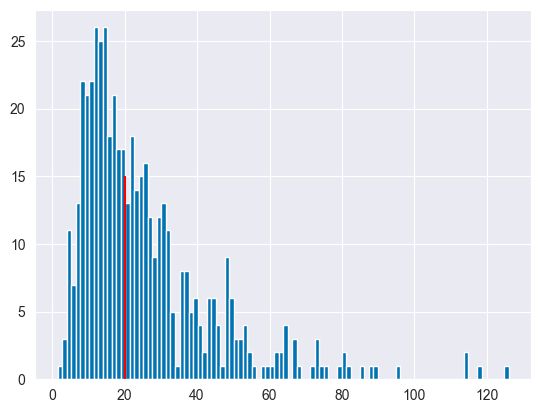

In [ ]:
n_nodes=500
mu = 20
plt.hist(np.random.lognormal(mean=np.log(mu),sigma=np.log(2),size=n_nodes), bins = 100)
plt.vlines(x=mu,ymin=0,ymax=15,colors="red")
plt.show()

In [ ]:
def generate_data_object_SBM(num_nodes, bip_block_probs, theta, bip_block_p_pass_probs):
    edges, labels = sample_dcsbm(num_nodes, bip_block_probs, theta) #generate_observations_tree_of_topics(n, n_students, n_tasks, tree_depth,branching_factor,p_ER,skill_mismatch_penalty)
    data = create_data_object_SBM(edges, labels, bip_block_p_pass_probs)
    # print("network density",data.num_edges/(2*n_students*n_tasks))
    return data

In [ ]:
num_nodes = 500
theta = np.random.lognormal(mean=np.log(20),sigma=np.log(2),size=num_nodes)
n_groups = 3
mul_p_connection = 1/2
dict_p_stud_to_task = {}
for i in range(n_groups):
    dict_p_stud_to_task[i] = [mul_p_connection/(n_groups-1)]*n_groups
    dict_p_stud_to_task[i][i] = 1
bip_block_probs = generate_bipartite_block_probs(dict_p_stud_to_task)

p_pass_out = .1
dict_p_pass_stud_to_task = {}
for i in range(n_groups):
    dict_p_pass_stud_to_task[i] = [p_pass_out]*n_groups
    dict_p_pass_stud_to_task[i][i] = 1
parameters_density['p_pass_out'] = p_pass_out
bip_block_p_pass_probs = generate_bipartite_block_probs(dict_p_pass_stud_to_task)

data = generate_data_object_SBM(num_nodes, bip_block_probs, theta, bip_block_p_pass_probs)


TypeError: create_data_object_SBM() missing 2 required positional arguments: 'theta' and 'base'

In [ ]:
grouped.reset_index(inplace=True)

In [ ]:
df.columns

In [ ]:
for p_val in grouped.p_pass_out.unique():
    print(p_val,grouped[grouped.p_pass_out == p_val].n_groups.unique())

In [ ]:
for p_val in grouped.p_pass_out.unique():
    print(grouped[grouped.p_pass_out == p_val].mul_p_connection.unique())

In [ ]:
grouped[grouped.p_pass_out == p_val]

In [ ]:
import numpy as np

In [ ]:
def sigmoid(x, alpha):
    return 1/(1+np.exp(-x/alpha))

In [ ]:
x = np.arange(-9,10)
plt.plot(x, [sigmoid(xi,0) for xi in x], label="alpha = 0")
plt.plot(x, [sigmoid(xi,1) for xi in x], label="alpha = 1")
plt.plot(x, [sigmoid(xi,2) for xi in x], label="alpha = 2")
plt.plot(x, [sigmoid(xi,3) for xi in x], label="alpha = 3")
plt.legend()

In [ ]:
import pathpy as pp
from collections import defaultdict 
import copy
# tree
root = "*"
max_depth = 3
nodes_at_layer = defaultdict(list)
nodes_at_layer[0].append(root)
start_nodes = ["0","1"]
nodes_at_layer[1].extend(start_nodes)
for depth in range(2,max_depth+1):
    # nodes_this_layer = []
    # nodes_prev_layer = copy.deepcopy(nodes_at_layer[depth-1])
    for node in nodes_at_layer[depth-1]:
        for base_node in start_nodes:
            nodes_at_layer[depth].append(node+base_node)


nodes_at_layer

In [ ]:
n = pp.Network(directed = True)
for depth in range(max(nodes_at_layer)):
    if depth == 0:
        for node in nodes_at_layer[1]:
            n.add_edge(root,node)
    else:
        for node_parent in nodes_at_layer[depth]:
            for node_child in nodes_at_layer[depth+1]:
                if node_child[:-1]==node_parent:
                    n.add_edge(node_parent,node_child)
print(n.ncount())
pp.visualisation.plot(n, width = 800,height = 800)

In [ ]:
nodes = list(n.nodes)
n_items = 100
# NB: randomly sampling nodes will disproportionately give leaves, i.e., difficult items.
item_positions = np.random.choice(nodes,size=n_items)
dict_item_positions = dict(zip(range(n_items),item_positions))

In [ ]:
def assign_skills(n, study_hours,root="*"):
    # gives skills to students
    # we start by taking one random path from root to leaf for each student
    # extensions goes in the direction of using personalized pagerank from the root node and would include: 
    #   study hours (similar to ability, encodes number of transitions taken by the students rw)
    #   restart probability tau at any node
    #   once an end node is reached, student restards from prev visited node (or root) with prob 1
    #
    # for now just enough to reach one leaf
    T = n.transition_matrix().todense().T
    root_index = n.node_to_name_map()[root]
    ix_to_node = {v:k for k,v in n.node_to_name_map().items()}
    last_node_ix = root_index
    for _ in range(study_hours):
        last_node_ix = np.random.choice(range(n.ncount()),p=T[last_node_ix,:].tolist()[0])
    return ix_to_node[last_node_ix]


n_students = 100
dict_students_abilities = {stud_id:[] for stud_id in range(n_students)}
for stud_id in dict_students_abilities:
    # append, but potentially extend cause students can get skills in different branches
    dict_students_abilities[stud_id].append(assign_skills(n,depth+1))
# dict_students_abilities

In [ ]:
# students interact randomly with items (erdos renyi). Student pass items if they have traversed the topic/tree-node in their learning path
p_ER = .3
edges = []
labels = []
for stud_id in dict_students_abilities:
    for item_id in dict_item_positions:
        if np.random.rand()<p_ER:
            edges.append((stud_id,item_id))
            # deciding if item is passed
            # could be made more nuanced checking how much of the path to the item_topic has been traversed by the student
            item_topic = dict_item_positions[item_id] 
            student_skills = dict_students_abilities[stud_id]
            if any([item_topic==skill[:len(item_topic)] for skill in student_skills if len(skill)>=len(item_topic)]):
                labels.append(1)
            else:
                labels.append(0)

print(sum(labels)/len(labels))

In [ ]:
# GENERATING NODE POSITIONS AND PLOTTING THEM 
# NB: ALSO SETTING RADIUS USED BELOW

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
dimension = 2
n_students = 270
n_items = 750
#
student_geom = np.random.rand(n_students,dimension)
student_ids = range(n_students)
items_geom = np.random.rand(n_items,dimension)
items_id = range(n_students, n_students+n_items)
#
radius = .1
fig,ax = plt.subplots()
ax.scatter(student_geom[:,0],student_geom[:,1], label = "student")
ax.scatter(items_geom[:,0],items_geom[:,1], label = "item")
plt.xlabel("Student ability")
plt.ylabel("Item diffuculty")
circle = Circle([.5,.5], radius, fill=False, edgecolor='red')
ax.add_patch(circle)
plt.legend()


In [ ]:
# GENERATING NODE POSITIONS AND PLOTTING THEM 
# NB: ALSO SETTING RADIUS USED BELOW

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
dimension = 2
n_students = 270
n_items = 750
#
student_geom = np.random.rand(n_students,dimension)
student_ids = range(n_students)
items_geom = np.random.rand(n_items,dimension)
items_id = range(n_students, n_students+n_items)
#
radius = .1
fig,ax = plt.subplots()
ax.scatter(student_geom[:,0],[0]*len(student_geom[:,1]), label = "student")
ax.scatter([0]*len(items_geom[:,0]),items_geom[:,1], label = "item")
plt.xlabel("Student ability")
plt.ylabel("Item diffuculty")
# circle = Circle([.5,.5], radius, fill=False, edgecolor='red')
# ax.add_patch(circle)
plt.legend()

In [ ]:
np.random.rand()

In [ ]:
n_students = 100
n_items = 150

list_a = [np.random.randint(50)/50 for _ in range(n_students)]
list_i = [np.random.randint(50)/50 for _ in range(n_items)]

edges = []
for i in range(n_students):
    # ability student i
    a_i = list_a[i]
    for j in range(n_items):
        # difficulty item j
        d_j = list_i[j]
        # delta gives how appropriate taks diff is for student ability
        delta = abs(a_i - d_j)
        # probability of interaction prop to inverse of delta: 
        p_i_j = 1/(2+delta)**4
        assert p_i_j <= 1
        if np.random.rand()<p_i_j:
            edges.append((i,i+j))

In [ ]:
import pathpy as pp
n = pp.Network(directed=True)
for (u,v) in edges:
    n.add_edge(u,v)
pp.visualisation.plot(n, width =800,height = 800)

In [ ]:
# OBTAINING PROBABILITY (AND PLOTTING PATTERNS FOR ON EDGES -- POSITION TAKING AVERAGE BETWEEN NODES INVOLVED IN THE INTERACTIONS)
label_probs = []
list_edge_points = []
for i in range(n_students):
    for j in range(n_items):
        if np.linalg.norm(student_geom[i]-items_geom[j]) < radius:
            # first coordinate used as student ability 
            # second coordinate used as item difficulty
            x = student_geom[i][0]-items_geom[j][1]
            label_probs.append(1/(1+np.exp(-x)))
            list_edge_points.append((student_geom[i]+items_geom[j])/2)

list_edge_points = np.array(list_edge_points)
plt.xlabel("Student ability")
plt.ylabel("Item diffuculty")
plt.scatter(list_edge_points[:,0],list_edge_points[:,1], c=label_probs)
plt.colorbar()

In [ ]:

# # CREATING LIST OF EDGES
# # import pathpy as pp
# import numpy as np
# n = pp.Network()
# edges = []
# for i in range(n_students):
#     for j in range(n_items):
#         if np.linalg.norm(student_geom[i]-items_geom[j]) < radius:
#             edges.append((i,i+j))
#             n.add_edge(i,n_students+j)


# # COOL DRAGON-LIKE VISUALIZATION
# # pp.visualisation.plot(n, width =800,height = 800)